# Milestone 1: Data Preprocessing and Visualization Techniques using TensorFlow Datasets

This notebook provides a method of reading images from a local file system and preprocesses the images using [TensorFlow Datasets](https://www.tensorflow.org/datasets).

This notebook also shares methods to ensure data sanity is preserved when converting data from different formats to a machine learning pipeline.

## Mounting Data from Google Drive

If you are running this notebook on Colab and you would like to mount data from Google Drive, you can run the cell below and check if you are able to view the contents inside the `Data` folder.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!ls './drive/My Drive/Data/cars'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
cars.tfcache.data-00000-of-00001  test	 train_val_test_numpy.pkl
cars.tfcache.index		  train  validation


## Download Images 

Kaggle hosts the images needed for the milestones for this liveProject. We will use the [Cars dataset](https://www.kaggle.com/ajaykgp12/cars-wagonr-swift/version/2) which can either be downloaded directly from the link or by installing the `kaggle` library locally (`pip install kaggle`) and running `kaggle download <dataset-name>`. More information about downloading using CLI is available at [Kaggle datasets from command line](https://github.com/Kaggle/kaggle-api).

In [0]:
!ls './drive/My Drive/Data/cars/train/'

swift  wagonr


## Import Statements

These are the libraries that would be needed to run this notebook. If you miss any of the libraries below, you can run it by creating a new cell and the following command:
```!pip install <library-name>```

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

import tensorflow as tf

print(f"You are running TensorFlow version: {tf.__version__}")
AUTOTUNE = tf.data.experimental.AUTOTUNE

You are running TensorFlow version: 2.2.0


## Building Image Metadata

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize.

In [0]:
data_dir = "./drive/My Drive/Data/cars/train/"
data_dir = pathlib.Path(data_dir)
print(f"Image data is read from `{data_dir}`")

Image data is read from `drive/My Drive/Data/cars/train`


After downloading the images, you should now have a copy of the car dataset available.

The dataset directory contains 2 sub-directories, one for each class with each sub-directory containing train, validation and test folders.

In [0]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Number of images read from the path: {image_count}")

Number of images read from the path: 2400


In [0]:
class_names = np.array([item.name for item in data_dir.glob('*')])
print(f"The class names available under this dataset: {class_names}")

The class names available under this dataset: ['wagonr' 'swift']


In [0]:
for folder_name in class_names:
  print(f"Folder {folder_name} has {len(list(data_dir.glob(f'{folder_name}/*.jpg')))} images")

Folder wagonr has 1200 images
Folder swift has 1200 images


## Loading Images using `keras.preprocessing`

A simple way to load images into a deep learning pipeline is to use `tf.keras.preprocessing`.

In [0]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Define some parameters for the loader:

In [0]:
batch_size = 32
img_height = 100
img_width = 100
steps_per_epoch = np.ceil(image_count/batch_size)

In [0]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(img_height, img_width),
                                                     classes = list(class_names))

Found 2400 images belonging to 2 classes.


Inspect a batch:

In [0]:
def show_batch(image_batch, label_batch):
    '''Quick peak into a batch of images with its labels'''
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[label_batch[n]==1][0].title())
        plt.axis('off')

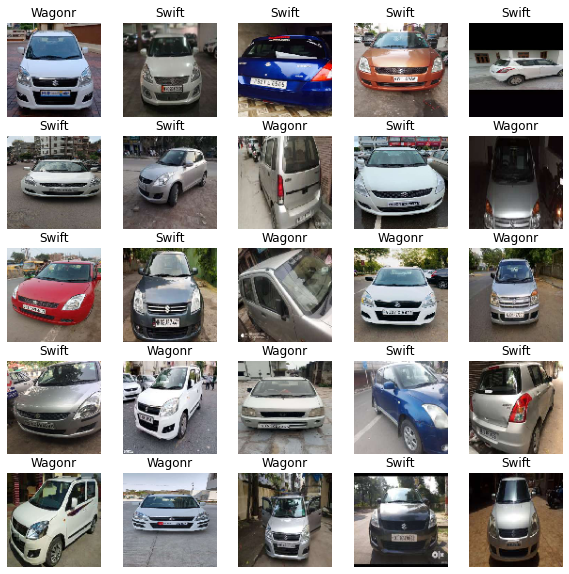

In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Loading Images using `tf.data`

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [0]:
for f in list_ds.take(5):
  print(f"Image path: {f.numpy()}")

Image path: b'drive/My Drive/Data/cars/train/swift/vsrimsxh6kha2-IN.jpg'
Image path: b'drive/My Drive/Data/cars/train/swift/mbj3xalwhawu2-IN.jpg'
Image path: b'drive/My Drive/Data/cars/train/wagonr/jibvqg97umym1-IN.jpg'
Image path: b'drive/My Drive/Data/cars/train/wagonr/14vplnltnbgn1-IN.jpg'
Image path: b'drive/My Drive/Data/cars/train/swift/ccyti4glm8721-IN.jpg'


Write a short pure-tensorflow function that converts a file path to an `(img, label)` pair:

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == class_names

## Image Processing Pipeline

This method would allow you to decode an image in JPEG format, normalize the image and resize it to the dimensions required. 
More information about building an image processing pipeline using TensorFlow is available [here](https://www.tensorflow.org/api_docs/python/tf/image).

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [img_width, img_height])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (100, 100, 3)
Label:  [ True False]


To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

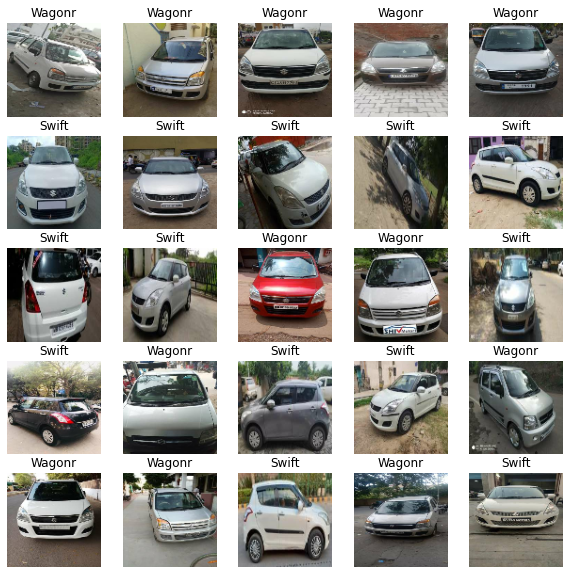

In [0]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Performance

Note: This section just shows a couple of easy tricks that may help performance. For an in depth guide see [Input Pipeline Performance](../../guide/performance/datasets).

To investigate, first here's a function to check the performance of our datasets:

In [0]:
import time
default_timeit_steps = 100

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(batch_size*steps/duration))

Let's compare the speed of the two data generators:

In [0]:
# `keras.preprocessing`
timeit(train_data_gen)

..........
100 batches: 923.9970183372498 s
3.46321 Images/s


In [0]:
# `tf.data`
timeit(train_ds)

..........
100 batches: 6.3803870677948 s
501.53697 Images/s


A large part of the performance gain comes from the use of `.cache`.

In [0]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

..........
100 batches: 10.96040391921997 s
291.96004 Images/s


If the dataset doesn't fit in memory use a cache file to maintain some of the advantages:

In [0]:
filecache_ds = prepare_for_training(labeled_ds, cache="./drive/My Drive/Data/cars/cars.tfcache")
timeit(filecache_ds)

..........
100 batches: 7.10555100440979 s
450.35213 Images/s


## Performance Comparison
As the above experiments show, the `tf.keras.preprocessing` pipeline is ~144x slower than the `tf.dataset` method of preprocessing. Deep learning utilizes batched data that are repeatedly utilized to train. Hence, it is imperative for us to use the best method to preprocess and feed images into the training pipeline.